In [1]:
import random
from copy import deepcopy
from time import perf_counter

In [2]:
STOCK_SIZE = 100

In [3]:
def read_instance(path):
    with open(path, 'r') as f:
        orders = [int(x) for x in f.readline().split()]
        return orders

In [4]:
def calc_solution_value(orders):
    
    leftovers = []
    num_stocks = 0
    current_stock_size = STOCK_SIZE
    for order in orders:
        if order <= current_stock_size:
            current_stock_size -= order
        else:
            leftover = current_stock_size
            leftovers.append(leftover)
            num_stocks += 1
            current_stock_size = STOCK_SIZE - order
    
    if current_stock_size != STOCK_SIZE:
        leftovers.append(current_stock_size)
        
    leftovers.sort(reverse = True)
        
    result = 0    
    for i, leftover in enumerate(leftovers):
        if leftover == 0:
            break
        result += (i+1) * leftover
        
    return result, num_stocks

In [5]:
def make_small_change(orders, num_orders):
    idxs = list(range(num_orders))
    random_length = random.randrange(1, num_orders)
    chosen = random.sample(idxs, k = random_length)
    for i in range(random_length):
        for j in range(chosen[i] + 1, num_orders):
            if orders[chosen[i]] != orders[j]:
                tmp = orders[chosen[i]]
                orders[chosen[i]] = orders[j]
                orders[j] = tmp
                break    

In [6]:
def initialize(orders):
    solution = deepcopy(orders)
    random.shuffle(solution)
    return solution

In [7]:
# nk - The number of the ordered small items by the length of l k .
# N - The number of all small items.
# li - The length of the i th ordered item.
# M - The number of all large objects. - moze da ne bude dato u zadatku vec da se izracuna u initialize f-ji
# Lj - The length of the j th large object.
# wj - The trim loss appeared on j th large object.
# Xij - A binary variable which is equal to one if the i th Item is cut from the j th large object and
# zero otherwise.
# wj = Lj − for i in range(N) for j in range(M)(li * xij) - calc trim loss 
# 0 <= wj <= Lj - logicno

# 0 < j < M - materijal koji imamo
# 0 < i < N - broj porucenih 

In [8]:
import math
from matplotlib import pyplot as plt

In [9]:
def simulated_annealing(orders, T, min_temperature, a):
    num_orders = len(orders)
    solution = initialize(orders)
    
    value, stocks_used = calc_solution_value(solution)
    best_solution = deepcopy(solution)
    best_value = value
    best_stocks_used = stocks_used

    PLT_VALUES = []
    PLT_STOCKS_USED = []
    ITERS = 0
    
    while T > min_temperature:
        new_solution = deepcopy(solution)
        make_small_change(new_solution, num_orders)
        new_value, new_stocks_used = calc_solution_value(new_solution)
        
        diff = new_value - value
        if diff < 0:
            solution = deepcopy(new_solution)
            value = new_value
            stocks_used = new_stocks_used
            if new_value < best_value:
                best_value = new_value
                best_solution = deepcopy(new_solution)
                best_stocks_used = new_stocks_used
        elif random.random() < (math.e)**((-diff) / T):
                value = new_value
                solution = deepcopy(new_solution)
                stocks_used = new_stocks_used
        T = a * T
        
        PLT_VALUES.append(value)
        PLT_STOCKS_USED.append(stocks_used)
        ITERS += 1
        
    plt.plot(range(ITERS), PLT_VALUES, label='Value')
    plt.legend()
    plt.show()
    
    plt.plot(range(ITERS), PLT_STOCKS_USED, label='Stocks used')
    plt.legend()
    plt.show()
    
    return best_solution, best_value, best_stocks_used

In [10]:
orders = [20, 30, 50, 10, 5, 5, 80, 35, 25, 40, 8, 12, 33, 27, 20, 90, 10, 90, 2, 3, 4, 1]
random.shuffle(orders)

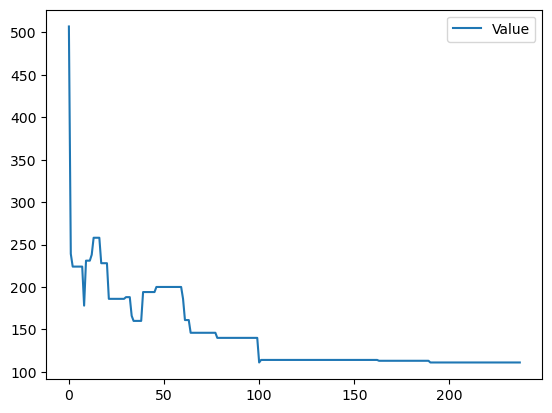

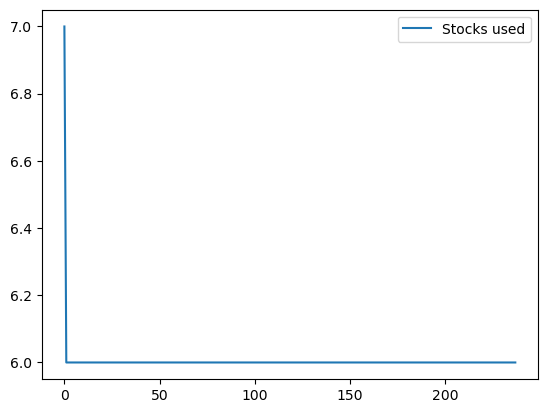

[12, 2, 3, 50, 25, 8, 1, 90, 80, 20, 90, 10, 30, 27, 33, 5, 4, 40, 35, 5, 20, 10] 111 6


In [11]:
solution, value, stocks_used = simulated_annealing(orders, T=200, min_temperature=1e-3, a=0.95)
print(solution, value, stocks_used)

In [22]:
orders = read_instance('test_instances/test_instance_20.csp')
initial_value, initial_stocks_used = calc_solution_value(orders)
print(initial_value, initial_stocks_used)

4478851 751


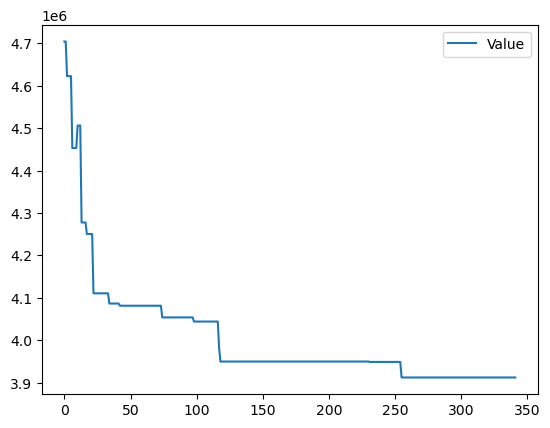

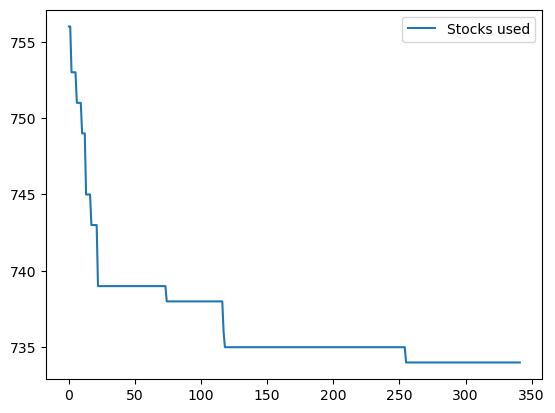

3912261 734


In [23]:
solution, value, stocks_used = simulated_annealing(orders, T=40000, min_temperature=1e-3, a=0.95)
print(value, stocks_used)

In [24]:
orders = read_instance('test_instances/test_instance_6.csp')
initial_value, initial_stocks_used = calc_solution_value(orders)
print(initial_value, initial_stocks_used)

137384 118


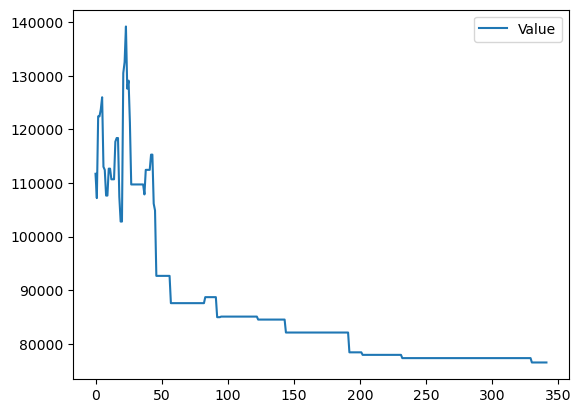

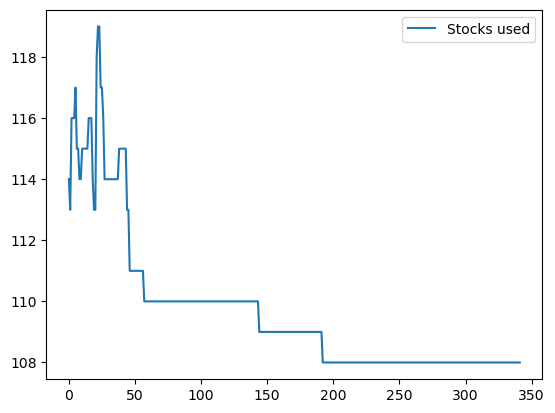

76504 108


In [25]:
solution, value, stocks_used = simulated_annealing(orders, T=40000, min_temperature=1e-3, a=0.95)
print(value, stocks_used)

In [38]:
POPULATION_SIZE = 100
NUM_ITERS = 10
ELITISM_SIZE = 20
MUTATION_PROB = 0.05
TOURNAMENT_SIZE = 5

class Individual:
    def __init__(self, orders):
        code = deepcopy(orders)
        random.shuffle(code)
        self.code = code
        self.fitness, self.num_stocks = calc_solution_value(orders)

In [54]:
def ga(orders):
    population = [Individual(orders) for _ in range(POPULATION_SIZE)]
    new_population = [Individual(orders) for _ in range(POPULATION_SIZE)]
    
    PLT_VALUES = []
    PLT_STOCKS_USED = []
    
    for _ in range(NUM_ITERS):
        population.sort(key=lambda x: x.fitness)
        new_population[:ELITISM_SIZE] = population[:ELITISM_SIZE]
        
        PLT_VALUES.append(population[0].fitness)
        PLT_STOCKS_USED.append(population[0].num_stocks)

        for i in range(ELITISM_SIZE, POPULATION_SIZE, 2):
            parent1 = selection(population, None)
            parent2 = selection(population, parent1)
            
            crossover(parent1, parent2, new_population[i], new_population[i+1])
            
            mutation(new_population[i], MUTATION_PROB)
            mutation(new_population[i+1], MUTATION_PROB)
            
            new_population[i].fitness, new_population[i].num_stocks = calc_solution_value(new_population[i].code)
            new_population[i+1].fitness, new_population[i+1].num_stocks = calc_solution_value(new_population[i+1].code)
        
        population[:] = new_population[:]
    
    plt.plot(range(NUM_ITERS), PLT_VALUES, label='Value')
    plt.legend()
    plt.show()
    
    plt.plot(range(NUM_ITERS), PLT_STOCKS_USED, label='Stocks used')
    plt.legend()
    plt.show()
    
    best_individual = min(population, key=lambda x: x.fitness)
    return best_individual.code, best_individual.fitness, best_individual.num_stocks

In [55]:
def selection(population, forbidden):
    allowed = list(set(population).difference({forbidden}))
    chosen = random.sample(allowed, TOURNAMENT_SIZE)
    return min(chosen, key=lambda x: x.fitness)

In [56]:
def crossover(parent1, parent2, child1, child2):
    pos = random.randrange(1, len(parent1.code))
    
    child1.code[:pos] = parent1.code[:pos]
    child1.code[pos:] = parent2.code[pos:]
    
    child2.code[:pos] = parent2.code[:pos]
    child2.code[pos:] = parent1.code[pos:]

In [57]:
def mutation(instance, prob):
    if random.random() < prob:
        pos1 = random.randrange(len(instance.code))
        pos2 = random.randrange(len(instance.code))
        
        tmp = instance.code[pos1]
        instance.code[pos1] = instance.code[pos2]
        instance.code[pos2] = tmp

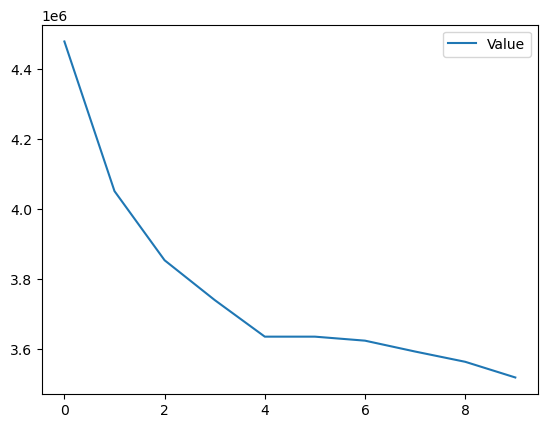

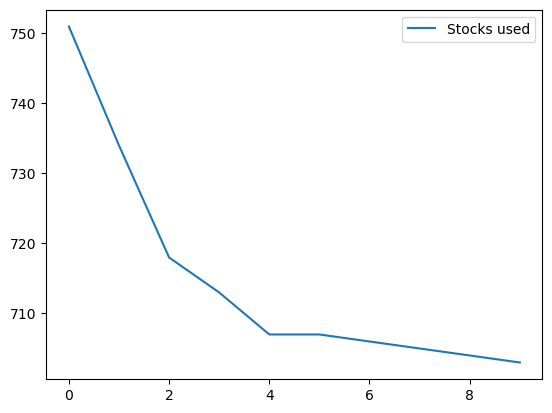

3518574 703


In [61]:
orders = read_instance('test_instances/test_instance_20.csp')
solution, value, num_stocks = ga(orders)
print(value, num_stocks)

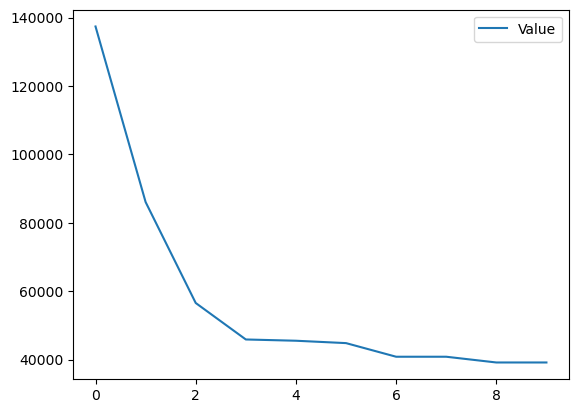

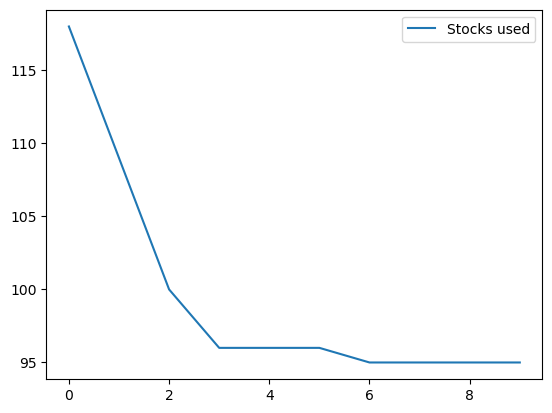

38472 95


In [58]:
orders = read_instance('test_instances/test_instance_6.csp')
solution, value, num_stocks = ga(orders)
print(value, num_stocks)

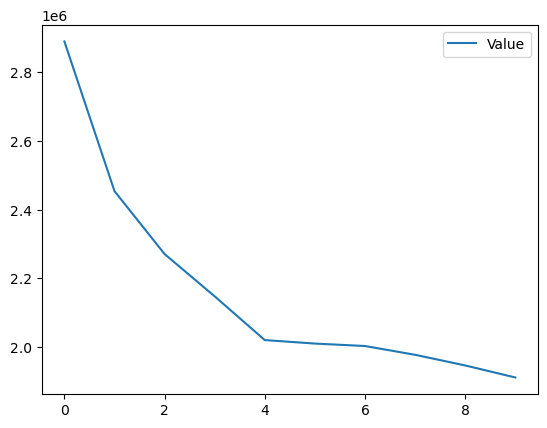

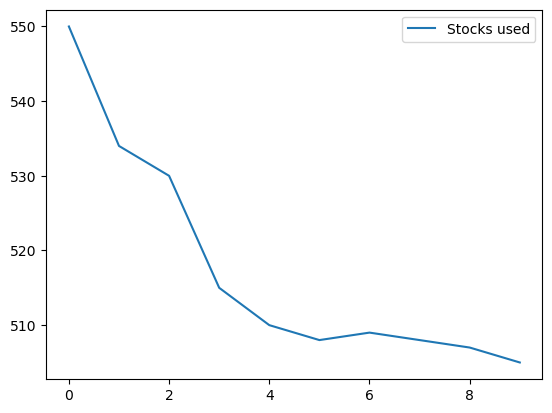

1883883 504


In [62]:
orders = read_instance('test_instances/test_instance_18.csp')
solution, value, num_stocks = ga(orders)
print(value, num_stocks)